In [1]:
from dask_jobqueue import HTCondorCluster
from dask.distributed import Client
import pde
import phasesep as ps
import shutil
import os
from pathlib import Path
import numpy as np


/home/ole.berendes/miniconda3/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


 ## Setting  up Dask cluster

In [2]:
cluster = HTCondorCluster(
    cores=1,
    memory="5GB",
    disk="10GB",
    processes=1,
    local_directory="$TMPDIR",
    log_directory="/home/ole.berendes/dasklogs",
    job_extra={"+MaxRunTime": 86400}
)


In [3]:
cluster.scale(1)
cluster


In [4]:
client = Client(cluster)


 ## Setting up the system

 ### Free energy density

In [5]:
f_scale = 1
f_slope = 0.02
f_offset = 0
kappa = 1
diffusive_mobility = 1
noise_diffusion = 2/30


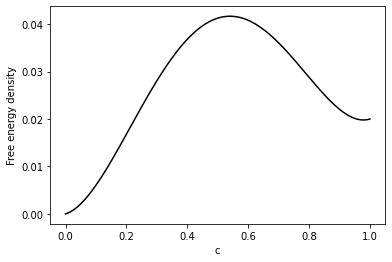

In [6]:

f = ps.GinzburgLandau2Components(
    prefactor=f_scale,
    slope=f_slope,
    offset=f_offset
)
f.plot()

In [7]:
binodal = f.get_binodal()[0][0]
spinodal = f.get_spinodal()[0]
binodal_range = spinodal - binodal


 ### Equation

In [8]:
eq = ps.CahnHilliardExtendedPDE(
    {
        "free_energy": f,
        "kappa": kappa,
        "mobility": diffusive_mobility,
        "noise_diffusion": noise_diffusion
    }
)


 ## Solve pde

 ### Define grid

In [9]:
nx, ny = 32, 32
x_start, x_end = -16, 16
y_start, y_end = -16, 16
grid = pde.CartesianGrid(
    bounds=[(x_start, x_end), (y_start, y_end)],
    shape=[nx,ny],
    periodic=True)


 ### Initial state

0.04226497308103739


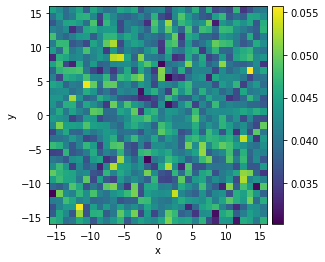

In [10]:
phi0 = binodal + 0.2*binodal_range

initial_field = pde.ScalarField.random_normal(
    grid=grid,
    mean=phi0,
    std=phi0*0.1
)
print(phi0)
initial_field.plot()

In [11]:
dt = 1e-3
def integrate(initial_state, t_end, dt=dt, eq=eq):
    storage = pde.MemoryStorage(field_obj=initial_state, write_mode="truncate_once")
    stor = storage.tracker()
    plot = pde.PlotTracker(interval=60, output_file="/home/ole.berendes/monitor.png")
    final = eq.solve(
        state=initial_state,
        t_range=t_end,
        tracker=[stor, plot],
        method="explicit",
        dt=dt
    )
    np.savez_compressed(
        "home/ole.berendes/data/traj.npz",
        *storage.data
    )
    return final



In [12]:
future = client.submit(integrate, initial_field, 1e5)


In [139]:
client.close()
cluster.close()


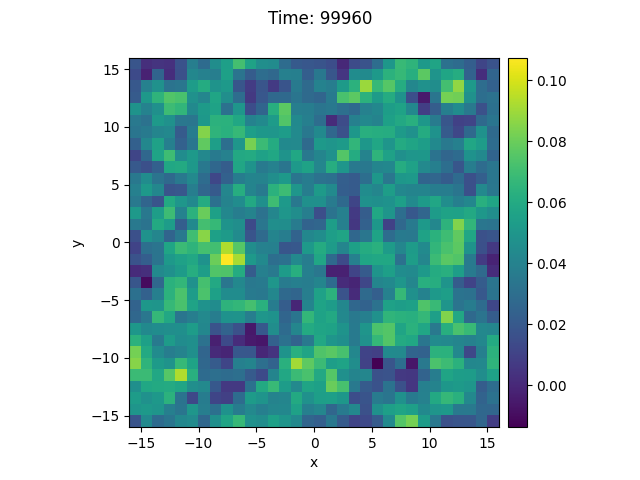

In [5]:
from IPython.display import Image
Image(filename='/home/ole.berendes/monitor.png')